# Flexible Component Placement Research

This notebook explores advanced algorithms for dynamically placing newsletter components with flexible shapes.

## Problem Statement

Given:
- A grid of 12x16 cells
- Components with different sizes and counts
- **Flexible quick_link components** - can be either 6×1 or 4×2
- **github_repo components** instead of secondary
- Components cannot be rotated
- Need to find optimal placement to minimize wasted space

## Component Specifications

From our config:
- 5 headlines: 5×4 each
- 1 github_repo: 3×3
- 3 brandings: 2×2 each
- 6 quick_links: flexible shapes (6×1 or 4×2) - total count matters, not individual shape

## Key Challenge

The main challenge is determining the optimal combination of quick_link shapes to fit the available space while minimizing waste.


In [145]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import random
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
from copy import deepcopy
from itertools import product

# Load configuration
with open('../config/component_placement_config.json', 'r') as f:
    config = json.load(f)

print("Grid Configuration:")
print(f"Columns: {config['grid_config']['columns']}")
print(f"Rows: {config['grid_config']['rows']}")
print(f"Cell Size: {config['grid_config']['cell_size']}px")

print("\nComponent Specifications:")
for component in config['components']:
    if 'shapes' in component:
        print(f"- {component['name']}: {component['total_count']} total with flexible shapes {component['shapes']}")
    else:
        print(f"- {component['name']}: {component['width']}x{component['height']} (count: {component['count']})")


Grid Configuration:
Columns: 12
Rows: 16
Cell Size: 48px

Component Specifications:
- headline: 5x4 (count: 4)
- github_repo: 3x3 (count: 1)
- branding: 2x2 (count: 3)
- quick_link: 6 total with flexible shapes [{'width': 6, 'height': 1}, {'width': 4, 'height': 2}]


In [146]:
@dataclass
class Component:
    name: str
    width: int
    height: int
    count: int
    can_rotate: bool
    priority: int
    color: str
    
    def __post_init__(self):
        self.instances = []
        for i in range(self.count):
            self.instances.append({
                'id': f"{self.name}_{i+1}",
                'width': self.width,
                'height': self.height,
                'placed': False,
                'position': None
            })

@dataclass
class FlexibleComponent:
    name: str
    shapes: List[Dict[str, int]]
    total_count: int
    can_rotate: bool
    priority: int
    color: str
    
    def __post_init__(self):
        self.instances = []
        # We'll generate instances dynamically based on shape combinations

@dataclass
class Placement:
    component_id: str
    x: int
    y: int
    width: int
    height: int
    color: str

class FlexibleGridPlacer:
    def __init__(self, grid_width: int, grid_height: int):
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.grid = np.zeros((grid_height, grid_width), dtype=int)
        self.placements = []
        
    def can_place(self, x: int, y: int, width: int, height: int) -> bool:
        """Check if a component can be placed at the given position"""
        if x + width > self.grid_width or y + height > self.grid_height:
            return False
        if x < 0 or y < 0:
            return False
            
        # Check if the area is free
        return np.all(self.grid[y:y+height, x:x+width] == 0)
    
    def place_component(self, component_id: str, x: int, y: int, width: int, height: int, color: str) -> bool:
        """Place a component at the given position"""
        if not self.can_place(x, y, width, height):
            return False
            
        # Mark the grid cells as occupied
        self.grid[y:y+height, x:x+width] = 1
        
        # Add to placements
        self.placements.append(Placement(component_id, x, y, width, height, color))
        return True
    
    def get_available_positions(self, width: int, height: int) -> List[Tuple[int, int]]:
        """Get all available positions for a component of given size"""
        positions = []
        for y in range(self.grid_height - height + 1):
            for x in range(self.grid_width - width + 1):
                if self.can_place(x, y, width, height):
                    positions.append((x, y))
        return positions
    
    def get_first_available_position(self, width: int, height: int) -> Optional[Tuple[int, int]]:
        """Get the first available position (top-left to bottom-right)"""
        positions = self.get_available_positions(width, height)
        return positions[0] if positions else None


In [147]:
def generate_shape_combinations(flexible_component: FlexibleComponent) -> List[List[Dict[str, int]]]:
    """
    Generate all possible combinations of shapes for a flexible component
    that add up to the total count
    """
    shapes = flexible_component.shapes
    total_count = flexible_component.total_count
    combinations = []
    
    # Generate all possible combinations
    for combo in product(range(total_count + 1), repeat=len(shapes)):
        if sum(combo) == total_count:
            combination = []
            for i, count in enumerate(combo):
                if count > 0:
                    combination.extend([shapes[i]] * count)
            combinations.append(combination)
    
    return combinations

def evaluate_shape_combination(placer: FlexibleGridPlacer, shapes: List[Dict[str, int]], 
                             component_name: str, color: str) -> Tuple[bool, int, List[Placement]]:
    """
    Try to place a combination of shapes and return success status, 
    number placed, and placements made
    """
    # Create a copy of the placer to test this combination
    test_placer = FlexibleGridPlacer(placer.grid_width, placer.grid_height)
    test_placer.grid = placer.grid.copy()
    test_placer.placements = placer.placements.copy()
    
    placed_count = 0
    new_placements = []
    
    for i, shape in enumerate(shapes):
        width, height = shape['width'], shape['height']
        position = test_placer.get_first_available_position(width, height)
        
        if position:
            x, y = position
            component_id = f"{component_name}_{i+1}"
            success = test_placer.place_component(component_id, x, y, width, height, color)
            if success:
                placed_count += 1
                new_placements.append(Placement(component_id, x, y, width, height, color))
            else:
                break
        else:
            break
    
    return placed_count == len(shapes), placed_count, new_placements

def flexible_placement_algorithm(components: List[Component], flexible_components: List[FlexibleComponent], 
                                grid_width: int, grid_height: int) -> FlexibleGridPlacer:
    """
    Advanced placement algorithm that handles flexible component shapes
    """
    placer = FlexibleGridPlacer(grid_width, grid_height)
    
    # First, place all fixed-size components
    print("Placing fixed-size components...")
    for component in components:
        for instance in component.instances:
            position = placer.get_first_available_position(instance['width'], instance['height'])
            if position:
                x, y = position
                success = placer.place_component(
                    instance['id'], x, y, 
                    instance['width'], instance['height'], 
                    component.color
                )
                if success:
                    instance['placed'] = True
                    instance['position'] = (x, y)
                    print(f"Placed {instance['id']} at ({x}, {y})")
                else:
                    print(f"Failed to place {instance['id']}")
            else:
                print(f"No space for {instance['id']}")
    
    # Then, place flexible components
    print("\nPlacing flexible components...")
    for flexible_component in flexible_components:
        print(f"\nProcessing {flexible_component.name} (need {flexible_component.total_count} total)...")
        
        # Generate all possible shape combinations
        combinations = generate_shape_combinations(flexible_component)
        print(f"Found {len(combinations)} possible shape combinations")
        
        best_combination = None
        best_placed = 0
        best_placements = []
        
        # Try each combination
        for i, combination in enumerate(combinations):
            success, placed_count, placements = evaluate_shape_combination(
                placer, combination, flexible_component.name, flexible_component.color
            )
            
            if placed_count > best_placed:
                best_placed = placed_count
                best_combination = combination
                best_placements = placements
                
            # If we placed all components, we can stop
            if success and placed_count == flexible_component.total_count:
                break
        
        # Apply the best combination
        if best_combination and best_placements:
            for placement in best_placements:
                placer.placements.append(placement)
                # Update the grid
                placer.grid[placement.y:placement.y+placement.height, 
                          placement.x:placement.x+placement.width] = 1
            
            print(f"Best combination placed {best_placed}/{flexible_component.total_count} components")
            shape_strs = [f"{s['width']}x{s['height']}" for s in best_combination]
            print(f"Shape combination: {shape_strs}")
        else:
            print(f"Could not place any {flexible_component.name} components")
    
    return placer


In [148]:
def visualize_placement(placer: FlexibleGridPlacer, title: str = "Flexible Component Placement"):
    """Visualize the component placement with colorful boxes"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 16))
    
    # Draw grid
    for i in range(placer.grid_height + 1):
        ax.axhline(y=i, color='black', linewidth=0.5, alpha=0.3)
    for i in range(placer.grid_width + 1):
        ax.axvline(x=i, color='black', linewidth=0.5, alpha=0.3)
    
    # Draw placed components
    for placement in placer.placements:
        rect = patches.Rectangle(
            (placement.x, placement.y), 
            placement.width, 
            placement.height,
            linewidth=2, 
            edgecolor='black', 
            facecolor=placement.color,
            alpha=0.7
        )
        ax.add_patch(rect)
        
        # Add component ID text
        center_x = placement.x + placement.width / 2
        center_y = placement.y + placement.height / 2
        ax.text(center_x, center_y, placement.component_id, 
                ha='center', va='center', fontsize=8, fontweight='bold')
    
    ax.set_xlim(-0.5, placer.grid_width + 0.5)
    ax.set_ylim(-0.5, placer.grid_height + 0.5)
    ax.set_aspect('equal')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Columns')
    ax.set_ylabel('Rows')
    ax.invert_yaxis()  # Invert y-axis so (0,0) is top-left
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_cells = placer.grid_width * placer.grid_height
    occupied_cells = np.sum(placer.grid)
    wasted_cells = total_cells - occupied_cells
    efficiency = (occupied_cells / total_cells) * 100
    
    print(f"\nPlacement Statistics:")
    print(f"Total grid cells: {total_cells}")
    print(f"Occupied cells: {occupied_cells}")
    print(f"Wasted cells: {wasted_cells}")
    print(f"Efficiency: {efficiency:.1f}%")
    print(f"Components placed: {len(placer.placements)}")
    
    # Count by component type
    component_counts = {}
    for placement in placer.placements:
        comp_type = placement.component_id.split('_')[0]
        component_counts[comp_type] = component_counts.get(comp_type, 0) + 1
    
    print(f"\nComponent breakdown:")
    for comp_type, count in component_counts.items():
        print(f"  {comp_type}: {count}")


In [149]:
# Create component objects from config
components = []
flexible_components = []

for comp_config in config['components']:
    if 'shapes' in comp_config:
        # This is a flexible component
        flexible_component = FlexibleComponent(
            name=comp_config['name'],
            shapes=comp_config['shapes'],
            total_count=comp_config['total_count'],
            can_rotate=comp_config['can_rotate'],
            priority=comp_config['priority'],
            color=comp_config['color']
        )
        flexible_components.append(flexible_component)
    else:
        # This is a fixed-size component
        component = Component(
            name=comp_config['name'],
            width=comp_config['width'],
            height=comp_config['height'],
            count=comp_config['count'],
            can_rotate=comp_config['can_rotate'],
            priority=comp_config['priority'],
            color=comp_config['color']
        )
        components.append(component)

# Get grid dimensions
grid_width = config['grid_config']['columns']
grid_height = config['grid_config']['rows']

print(f"Grid size: {grid_width}x{grid_height}")
print(f"Total available cells: {grid_width * grid_height}")

# Calculate total space needed
total_space_needed = 0
for component in components:
    space_per_component = component.width * component.height
    total_space = space_per_component * component.count
    total_space_needed += total_space
    print(f"{component.name}: {space_per_component} cells each × {component.count} = {total_space} cells")

# For flexible components, calculate minimum space needed
for flexible_component in flexible_components:
    min_space = min(shape['width'] * shape['height'] for shape in flexible_component.shapes)
    total_min_space = min_space * flexible_component.total_count
    total_space_needed += total_min_space
    print(f"{flexible_component.name}: minimum {min_space} cells each × {flexible_component.total_count} = {total_min_space} cells (flexible)")

print(f"\nTotal space needed (minimum): {total_space_needed} cells")
print(f"Space available: {grid_width * grid_height} cells")
print(f"Can fit: {'Yes' if total_space_needed <= grid_width * grid_height else 'No'}")


Grid size: 12x16
Total available cells: 192
headline: 20 cells each × 4 = 80 cells
github_repo: 9 cells each × 1 = 9 cells
branding: 4 cells each × 3 = 12 cells
quick_link: minimum 6 cells each × 6 = 36 cells (flexible)

Total space needed (minimum): 137 cells
Space available: 192 cells
Can fit: Yes


Running Flexible Component Placement Algorithm...
Placing fixed-size components...
Placed headline_1 at (0, 0)
Placed headline_2 at (5, 0)
Placed headline_3 at (0, 4)
Placed headline_4 at (5, 4)
Placed github_repo_1 at (0, 8)
Placed branding_1 at (10, 0)
Placed branding_2 at (10, 2)
Placed branding_3 at (10, 4)

Placing flexible components...

Processing quick_link (need 6 total)...
Found 7 possible shape combinations
Best combination placed 6/6 components
Shape combination: ['4x2', '4x2', '4x2', '4x2', '4x2', '4x2']


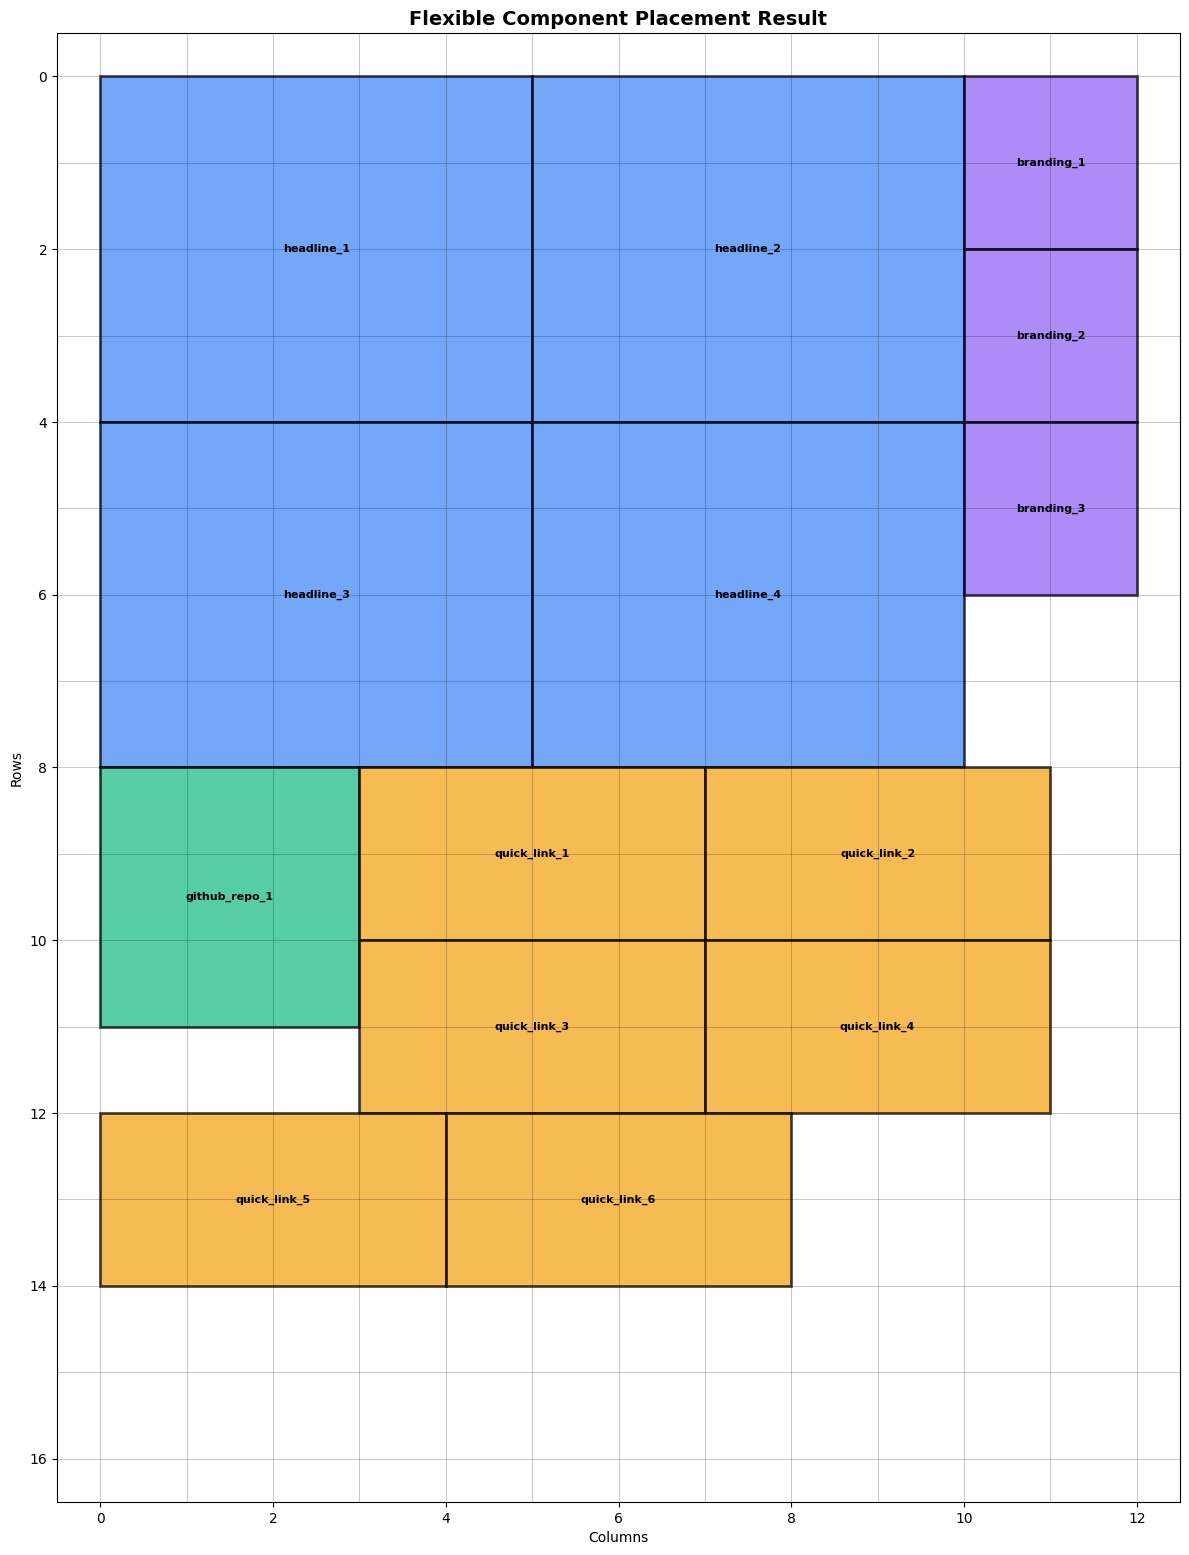


Placement Statistics:
Total grid cells: 192
Occupied cells: 149
Wasted cells: 43
Efficiency: 77.6%
Components placed: 14

Component breakdown:
  headline: 4
  github: 1
  branding: 3
  quick: 6


In [150]:
# Run the flexible placement algorithm
print("Running Flexible Component Placement Algorithm...")
print("=" * 60)

placer = flexible_placement_algorithm(components, flexible_components, grid_width, grid_height)

# Visualize the result
visualize_placement(placer, "Flexible Component Placement Result")


In [151]:
def random_brandings_flexible_rest_algorithm(components: List[Component], flexible_components: List[FlexibleComponent], 
                                           grid_width: int, grid_height: int) -> FlexibleGridPlacer:
    """
    Hybrid algorithm: Place brandings randomly first, then optimally place the rest with flexible shapes
    """
    placer = FlexibleGridPlacer(grid_width, grid_height)
    
    # Separate brandings from other components
    branding_components = [c for c in components if c.name == 'branding']
    other_components = [c for c in components if c.name != 'branding']
    
    # Step 1: Place brandings randomly
    print("Step 1: Placing brandings randomly...")
    for component in branding_components:
        for instance in component.instances:
            if instance['placed']:
                continue
                
            # Get all available positions for branding
            positions = placer.get_available_positions(instance['width'], instance['height'])
            
            if positions:
                # Randomly select a position
                x, y = random.choice(positions)
                
                success = placer.place_component(
                    instance['id'], x, y, 
                    instance['width'], instance['height'], 
                    component.color
                )
                if success:
                    instance['placed'] = True
                    instance['position'] = (x, y)
                    print(f"Randomly placed {instance['id']} at ({x}, {y})")
                else:
                    print(f"Failed to place {instance['id']}")
            else:
                print(f"No space for {instance['id']}")
    
    # Step 2: Place remaining fixed components optimally
    print("\nStep 2: Placing remaining fixed components optimally...")
    for component in other_components:
        for instance in component.instances:
            if instance['placed']:
                continue
                
            position = placer.get_first_available_position(instance['width'], instance['height'])
            if position:
                x, y = position
                success = placer.place_component(
                    instance['id'], x, y, 
                    instance['width'], instance['height'], 
                    component.color
                )
                if success:
                    instance['placed'] = True
                    instance['position'] = (x, y)
                    print(f"Optimally placed {instance['id']} at ({x}, {y})")
                else:
                    print(f"Failed to place {instance['id']}")
            else:
                print(f"No space for {instance['id']}")
    
    # Step 3: Place flexible components optimally
    print("\nStep 3: Placing flexible components optimally...")
    for flexible_component in flexible_components:
        print(f"\nProcessing {flexible_component.name} (need {flexible_component.total_count} total)...")
        
        # Generate all possible shape combinations
        combinations = generate_shape_combinations(flexible_component)
        print(f"Found {len(combinations)} possible shape combinations")
        
        best_combination = None
        best_placed = 0
        best_placements = []
        
        # Try each combination
        for i, combination in enumerate(combinations):
            success, placed_count, placements = evaluate_shape_combination(
                placer, combination, flexible_component.name, flexible_component.color
            )
            
            if placed_count > best_placed:
                best_placed = placed_count
                best_combination = combination
                best_placements = placements
                
            # If we placed all components, we can stop
            if success and placed_count == flexible_component.total_count:
                break
        
        # Apply the best combination
        if best_combination and best_placements:
            for placement in best_placements:
                placer.placements.append(placement)
                # Update the grid
                placer.grid[placement.y:placement.y+placement.height, 
                          placement.x:placement.x+placement.width] = 1
            
            print(f"Best combination placed {best_placed}/{flexible_component.total_count} components")
            shape_strs = [f"{s['width']}x{s['height']}" for s in best_combination]
            print(f"Shape combination: {shape_strs}")
        else:
            print(f"Could not place any {flexible_component.name} components")
    
    return placer


Testing Random Brandings + Flexible Rest Algorithm...
Step 1: Placing brandings randomly...
Randomly placed branding_1 at (2, 6)
Randomly placed branding_2 at (10, 9)
Randomly placed branding_3 at (7, 0)

Step 2: Placing remaining fixed components optimally...
Optimally placed headline_1 at (0, 0)
Optimally placed headline_2 at (5, 2)
Optimally placed headline_3 at (4, 6)
Optimally placed headline_4 at (0, 10)
Optimally placed github_repo_1 at (9, 6)

Step 3: Placing flexible components optimally...

Processing quick_link (need 6 total)...
Found 7 possible shape combinations
Best combination placed 6/6 components
Shape combination: ['4x2', '4x2', '4x2', '4x2', '4x2', '4x2']


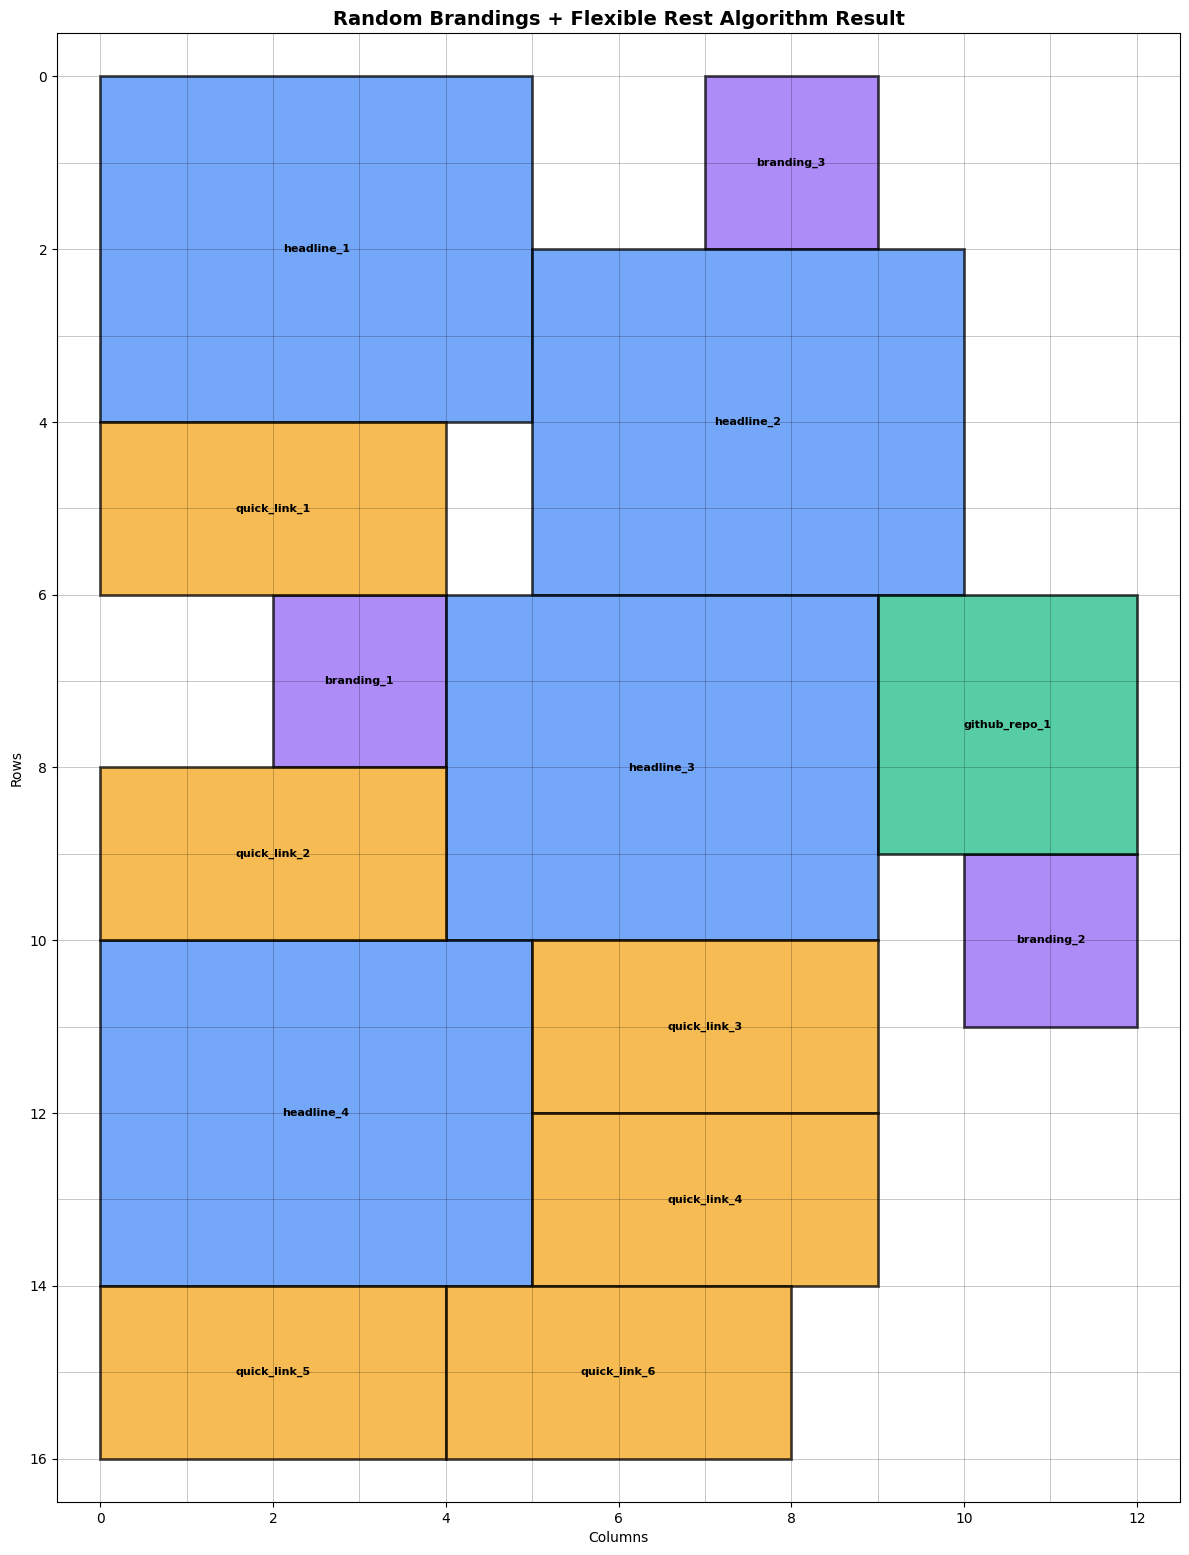


Placement Statistics:
Total grid cells: 192
Occupied cells: 149
Wasted cells: 43
Efficiency: 77.6%
Components placed: 14

Component breakdown:
  branding: 3
  headline: 4
  github: 1
  quick: 6


In [152]:
def reset_components(components):
    """Reset component instances for testing different algorithms"""
    for component in components:
        for instance in component.instances:
            instance['placed'] = False
            instance['position'] = None

# Test the new hybrid algorithm with randomness
print("Testing Random Brandings + Flexible Rest Algorithm...")
print("=" * 70)

# Reset components for testing
reset_components(components)

placer_hybrid = random_brandings_flexible_rest_algorithm(components, flexible_components, grid_width, grid_height)

# Visualize the result
visualize_placement(placer_hybrid, "Random Brandings + Flexible Rest Algorithm Result")


## Multiple Random Runs

Let's test multiple runs to see how different random branding placements affect the overall efficiency:


Testing Multiple Random Runs...

--- Run 1 ---
Step 1: Placing brandings randomly...
Randomly placed branding_1 at (3, 2)
Randomly placed branding_2 at (8, 6)
Randomly placed branding_3 at (1, 11)

Step 2: Placing remaining fixed components optimally...
Optimally placed headline_1 at (5, 0)
Optimally placed headline_2 at (0, 4)
Optimally placed headline_3 at (3, 8)
Optimally placed headline_4 at (3, 12)
Optimally placed github_repo_1 at (0, 0)

Step 3: Placing flexible components optimally...

Processing quick_link (need 6 total)...
Found 7 possible shape combinations
Best combination placed 6/6 components
Shape combination: ['6x1', '6x1', '4x2', '4x2', '4x2', '4x2']
Efficiency: 75.5%
Wasted cells: 47
Components placed: 14
Component breakdown: {'branding': 3, 'headline': 4, 'github': 1, 'quick': 6}


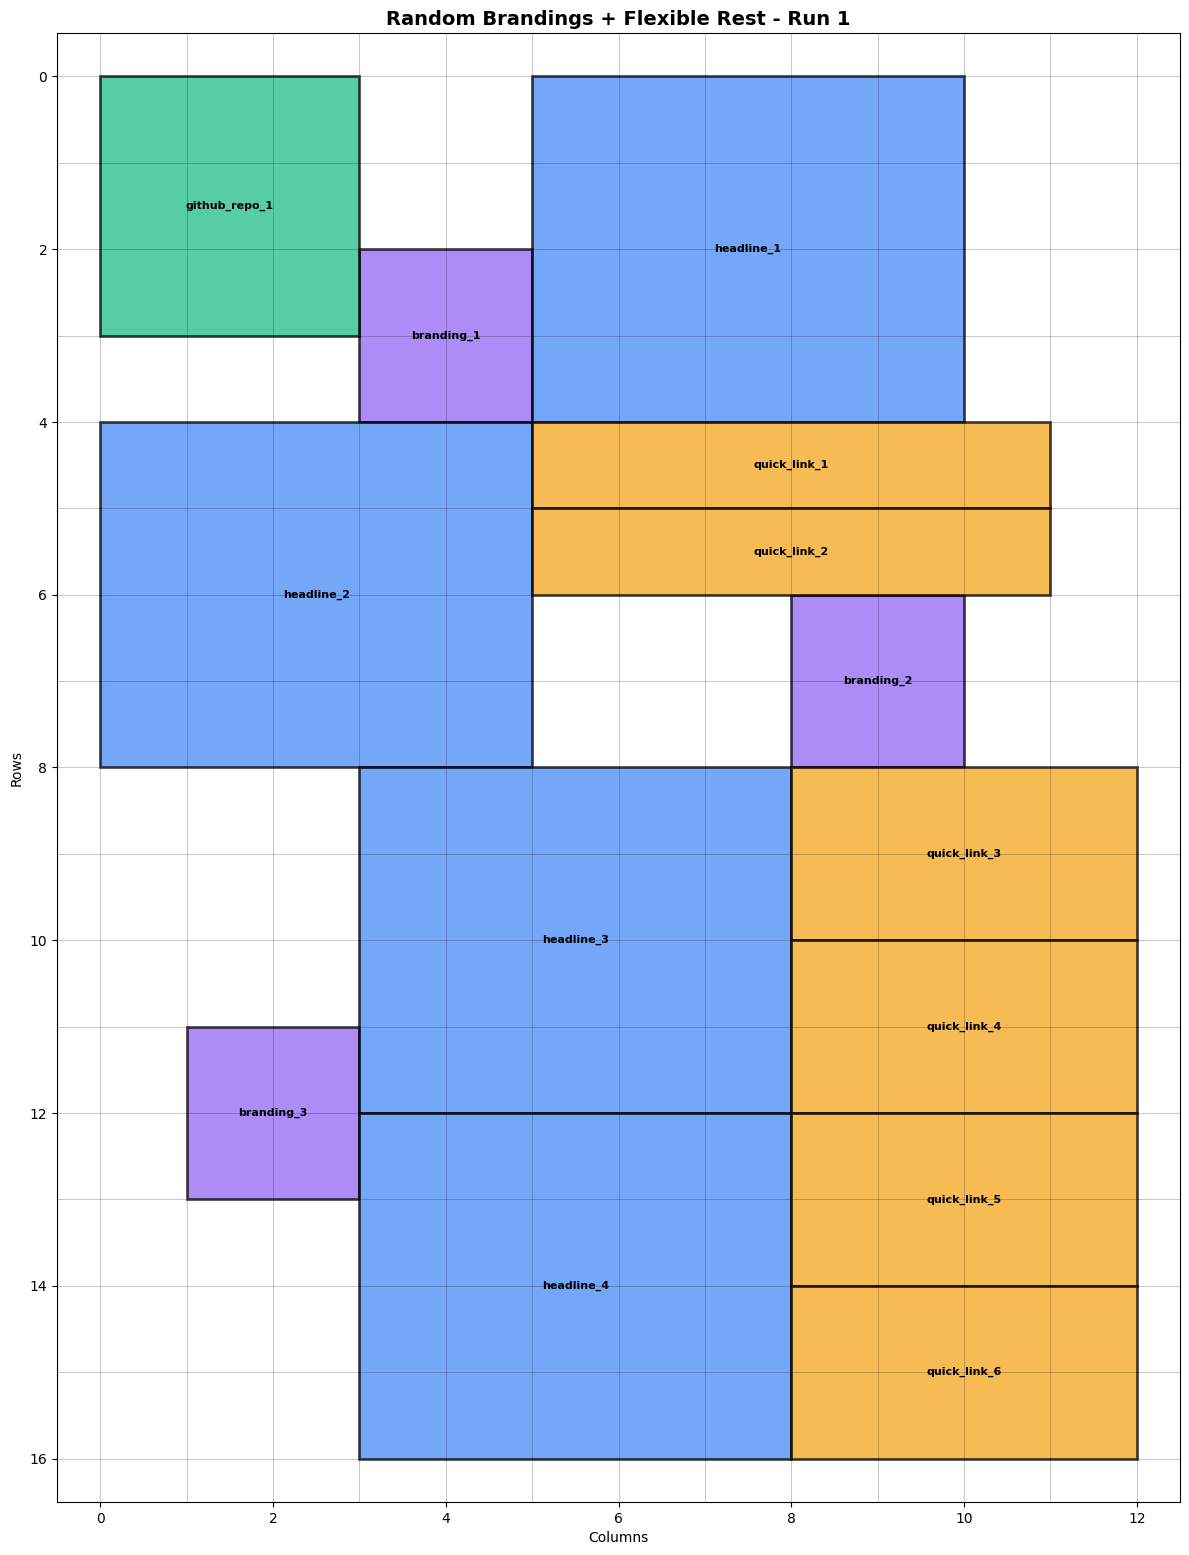


Placement Statistics:
Total grid cells: 192
Occupied cells: 145
Wasted cells: 47
Efficiency: 75.5%
Components placed: 14

Component breakdown:
  branding: 3
  headline: 4
  github: 1
  quick: 6

--- Run 2 ---
Step 1: Placing brandings randomly...
Randomly placed branding_1 at (1, 1)
Randomly placed branding_2 at (3, 13)
Randomly placed branding_3 at (1, 11)

Step 2: Placing remaining fixed components optimally...
Optimally placed headline_1 at (3, 0)
Optimally placed headline_2 at (0, 4)
Optimally placed headline_3 at (5, 4)
Optimally placed headline_4 at (3, 8)
Optimally placed github_repo_1 at (8, 0)

Step 3: Placing flexible components optimally...

Processing quick_link (need 6 total)...
Found 7 possible shape combinations
Best combination placed 6/6 components
Shape combination: ['6x1', '6x1', '6x1', '6x1', '4x2', '4x2']
Efficiency: 73.4%
Wasted cells: 51
Components placed: 14
Component breakdown: {'branding': 3, 'headline': 4, 'github': 1, 'quick': 6}

--- Run 3 ---
Step 1: Plac

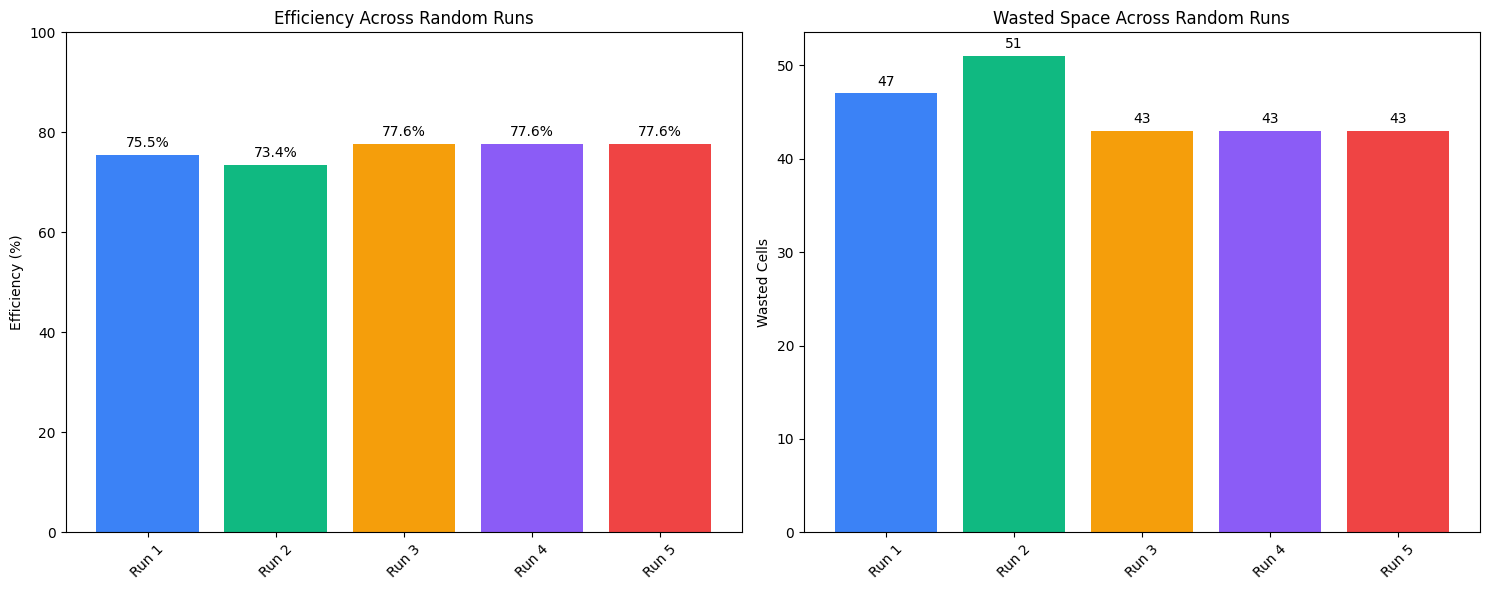

In [153]:
# Test multiple runs of the hybrid algorithm to see variation
print("Testing Multiple Random Runs...")
print("=" * 50)

results = []
num_runs = 5

for run in range(num_runs):
    print(f"\n--- Run {run + 1} ---")
    reset_components(components)
    placer_hybrid = random_brandings_flexible_rest_algorithm(components, flexible_components, grid_width, grid_height)
    
    # Calculate efficiency
    total_cells = grid_width * grid_height
    occupied_cells = np.sum(placer_hybrid.grid)
    efficiency = (occupied_cells / total_cells) * 100
    wasted_cells = total_cells - occupied_cells
    
    # Count components by type
    component_counts = {}
    for placement in placer_hybrid.placements:
        comp_type = placement.component_id.split('_')[0]
        component_counts[comp_type] = component_counts.get(comp_type, 0) + 1
    
    results.append({
        'run': run + 1,
        'efficiency': efficiency,
        'wasted_cells': wasted_cells,
        'total_placed': len(placer_hybrid.placements),
        'component_counts': component_counts
    })
    
    print(f"Efficiency: {efficiency:.1f}%")
    print(f"Wasted cells: {wasted_cells}")
    print(f"Components placed: {len(placer_hybrid.placements)}")
    print(f"Component breakdown: {component_counts}")
    
    # Show the visualization for the first run
    if run == 0:
        visualize_placement(placer_hybrid, f"Random Brandings + Flexible Rest - Run {run + 1}")

# Analyze results
print(f"\n{'='*60}")
print("RANDOM RUNS ANALYSIS")
print(f"{'='*60}")

efficiencies = [r['efficiency'] for r in results]
wasted_cells = [r['wasted_cells'] for r in results]

print(f"Efficiency - Min: {min(efficiencies):.1f}%, Max: {max(efficiencies):.1f}%, Avg: {np.mean(efficiencies):.1f}%")
print(f"Wasted cells - Min: {min(wasted_cells)}, Max: {max(wasted_cells)}, Avg: {np.mean(wasted_cells):.1f}")

# Find best and worst runs
best_run = max(results, key=lambda x: x['efficiency'])
worst_run = min(results, key=lambda x: x['efficiency'])

print(f"\nBest run: #{best_run['run']} with {best_run['efficiency']:.1f}% efficiency")
print(f"Worst run: #{worst_run['run']} with {worst_run['efficiency']:.1f}% efficiency")

# Create comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Efficiency comparison
runs = [f"Run {r['run']}" for r in results]
ax1.bar(runs, efficiencies, color=['#3B82F6', '#10B981', '#F59E0B', '#8B5CF6', '#EF4444'])
ax1.set_title('Efficiency Across Random Runs')
ax1.set_ylabel('Efficiency (%)')
ax1.set_ylim(0, 100)
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(efficiencies):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# Wasted space comparison
ax2.bar(runs, wasted_cells, color=['#3B82F6', '#10B981', '#F59E0B', '#8B5CF6', '#EF4444'])
ax2.set_title('Wasted Space Across Random Runs')
ax2.set_ylabel('Wasted Cells')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(wasted_cells):
    ax2.text(i, v + 0.5, f'{v}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
